# running simulations

In [ ]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import modules.plot_aux as pltt
import modules.hopfield as hopfield

plt.rcParams["mathtext.fontset"] = "dejavuserif"


# --- Setup ---
np.random.seed(42)       # setting RNG seed for reproducibility
L                 = 10   # Side length
N                 = L**2 # number of neurons in the network
noise_level_input = 0.3  # for generating IC from a given pattern
max_iter_sync     = 15
max_MCsteps_seq   = 10

# defining patterns to store
pattern_H  = hopfield.get_H_pattern(L)
pattern_X  = hopfield.get_X_pattern(L)
pattern_P  = hopfield.get_stripe_pattern(L) #
xi_lst_all = [pattern_H, pattern_X, pattern_P] # memory list

# Initialize network with H and X memories
W_HX, _, xi_lst_HX = hopfield.initialize_hopfield_model(xi_lst_all[:2])

# Iterating Hopfield model with only H and X patterns to retrieve them
s_init_HX      = [None for _ in xi_lst_HX]
s_final_HX     = [None for _ in xi_lst_HX]
E_lst_sync_HX  = [None for _ in xi_lst_HX]
E_lst_seq_HX   = [None for _ in xi_lst_HX]
m_lst_sync_HX  = [None for _ in xi_lst_HX]
m_lst_seq_HX   = [None for _ in xi_lst_HX]
for mu,xi in enumerate(xi_lst_HX):
    s_init_HX[mu]                                        = hopfield.add_noise(xi, noise_level=noise_level_input) # generating IC from the pattern we want to retrieve
    s_final_HX[mu], E_lst_sync_HX[mu], m_lst_sync_HX[mu] = hopfield.iterate_hopfield_synchronous(W_HX, s_init_HX[mu], max_iter   =max_iter_sync  , patterns=xi_lst_HX)
    _             , E_lst_seq_HX[mu] , m_lst_seq_HX[mu]  = hopfield.iterate_hopfield_sequential( W_HX, s_init_HX[mu], max_MCsteps=max_MCsteps_seq, patterns=xi_lst_HX)


# retrieving an antipattern
s_init_anti                        = -s_init_HX[1] # X pattern + noise, but with sign inverted
s_final_anti,E_seq_anti,m_seq_anti = hopfield.iterate_hopfield_sequential(W_HX, s_init_anti, max_MCsteps=max_MCsteps_seq, patterns=xi_lst_HX)

# retrieving hallucination (spurious pattern)
s_init_hall                          = hopfield.get_plus_pattern(L).reshape((L,L))
s_init_hall[3:,:]                    = -1
s_init_hall                          = s_init_hall.flatten()
s_final_hall,E_sync_hall,m_sync_hall = hopfield.iterate_hopfield_synchronous(W_HX, s_init_hall, max_iter=max_iter_sync, patterns=xi_lst_HX)


# Initialize network with 'H', 'X', '#' memories
W_all, _, _     = hopfield.initialize_hopfield_model(xi_lst_all)
s_init_all      = [None for _ in xi_lst_all]
s_final_all     = [None for _ in xi_lst_all]
E_lst_sync_all  = [None for _ in xi_lst_all]
E_lst_seq_all   = [None for _ in xi_lst_all]
m_lst_sync_all  = [None for _ in xi_lst_all]
m_lst_seq_all   = [None for _ in xi_lst_all]
for mu,xi in enumerate(xi_lst_all):
    s_init_all[mu]                                          = hopfield.add_noise(xi, noise_level=0.2)
    _              , E_lst_sync_all[mu], m_lst_sync_all[mu] = hopfield.iterate_hopfield_synchronous(W_all, s_init_all[mu], max_iter   =max_iter_sync  , patterns=xi_lst_all)
    s_final_all[mu], E_lst_seq_all[mu] , m_lst_seq_all[mu]  = hopfield.iterate_hopfield_sequential( W_all, s_init_all[mu], max_MCsteps=max_MCsteps_seq, patterns=xi_lst_all)

# retrieving hallucination (spurious pattern)
s0                                     = xi_lst_all[1].copy().reshape((L,L))
s0[:(L//3),:]                          = -1
s0[(2*L//3):,:]                        = -1
s_init_hall3                           = s0.flatten()
s_final_hall3,E_seq_hall3,m_seq_hall_3 = hopfield.iterate_hopfield_sequential(W_all, s_init_hall3, max_MCsteps=max_MCsteps_seq, patterns=xi_lst_all)



# 2 memories convergence

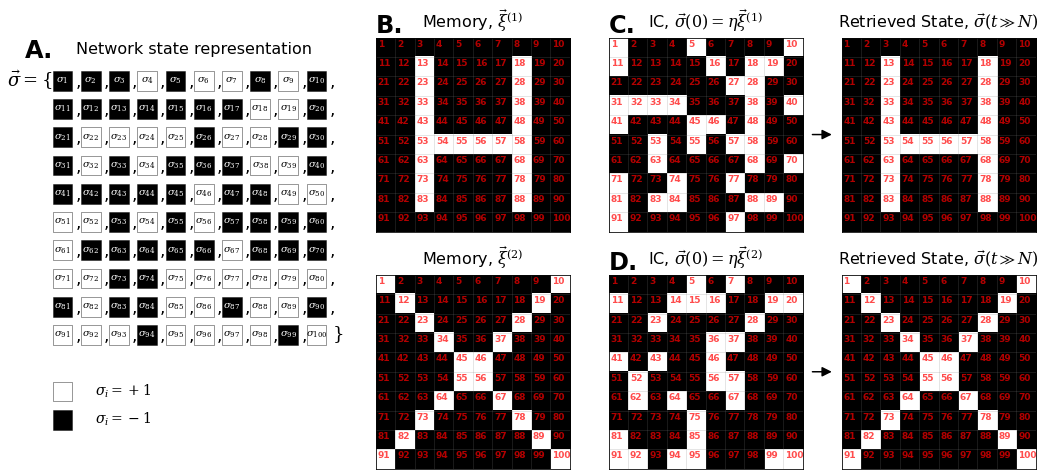

In [ ]:
xi_lst  = xi_lst_HX
s_init  = s_init_HX
s_final = s_final_HX


fig, axes = plt.subplots(len(xi_lst), 4, figsize=(16, 4 * len(xi_lst)), facecolor='w')
axes[1,0].set_visible(False)


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu, 1:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                N = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(N), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)


pltt.enlarge_axis(axes[0,0],1.6,dx=-0.04,dy=-0.12)
pltt.plot_vector_lattice_schematic(axes[0,0],hopfield.add_noise(pattern_H,0.5), L=10, fontsize_multiplier=0.5,grid_multiplier=0.7)
axes[0,0].text( 4.5, 9.7,'Network state representation',fontsize=16,ha='center',va='bottom')

axes[0,0].text(-1.5, 9.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,2].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,2].text(-0.5,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')


fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.05, 0.5), xyB=(-0.05, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,2], axesB=axes[0,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.05, 0.5), xyB=(-0.05, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,2], axesB=axes[1,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

#plt.tight_layout()

fig.savefig('figures/hopfield_2mem.png',dpi=300,bbox_inches='tight')

plt.show()

# hallucination and antimemory

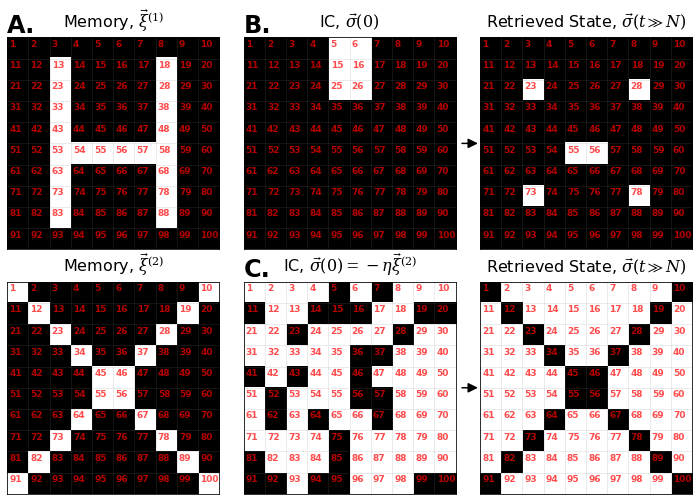

In [ ]:
xi_lst  = [ xi_lst_HX[0] , xi_lst_HX[1] ]
s_init  = [ s_init_hall  , s_init_anti  ]
s_final = [ s_final_hall , s_final_anti ]

fig, axes = plt.subplots(len(xi_lst), 3, figsize=(10,1+3*len(xi_lst)), facecolor='w')


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=-\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu,:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                N = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(N), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-0.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

axes[0,1].set_title(r'IC, $\vec{\sigma}(0)$',fontsize=16,pad=10)

fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,1], axesB=axes[0,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[1,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))


fig.savefig('figures/hopfield_2mem_hallucination_antimem_detail.png',dpi=300,bbox_inches='tight')

plt.show()

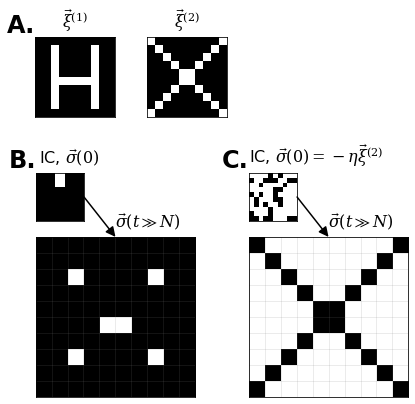

In [53]:
xi_lst  = [ xi_lst_HX[0] , xi_lst_HX[1] ]
s_init  = [ s_init_hall  , s_init_anti  ]
s_final = [ s_final_hall , s_final_anti ]

fig, axes = plt.subplots(3, len(xi_lst), figsize=(1+3*len(xi_lst),10), facecolor='w')


cmap = 'binary_r'

titles = [r'$\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=-\eta\vec{\xi}^{(%d)}$', 
          r'$\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[:,mu]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='none')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-4.0,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,0].text(-6.2,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-6.2,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

axes[1,0].set_title(r'IC, $\vec{\sigma}(0)$',fontsize=16,pad=10)

pltt.enlarge_axis(axes[0,0],0.5,dx= 0.0,dy=0.0)
pltt.enlarge_axis(axes[0,1],0.5,dx=-0.2,dy=0.0)
pltt.enlarge_axis(axes[0,:],1  ,dx=-0.08,dy=0.0)
pltt.enlarge_axis(axes[1,:],0.3,dx=-0.11, dy=0.1)
pltt.unset_minor_grid(axes[0:2,:])
pltt.shift_axes_title(axes[1,0],dx=0.2,dy=-1)
pltt.shift_axes_title(axes[1,1],dx=0.9,dy=-1)
pltt.enlarge_axis(axes[2,:],1,dx=0, dy=0.2)
pltt.shift_axes_title(axes[2,:],dx=0.2,dy=-1)

#fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,0], axesB=axes[2,0], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[2,1], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))


fig.savefig('figures/hopfield_2mem_hallucination_antimem.png',dpi=300,bbox_inches='tight')

plt.show()

# 3 memories

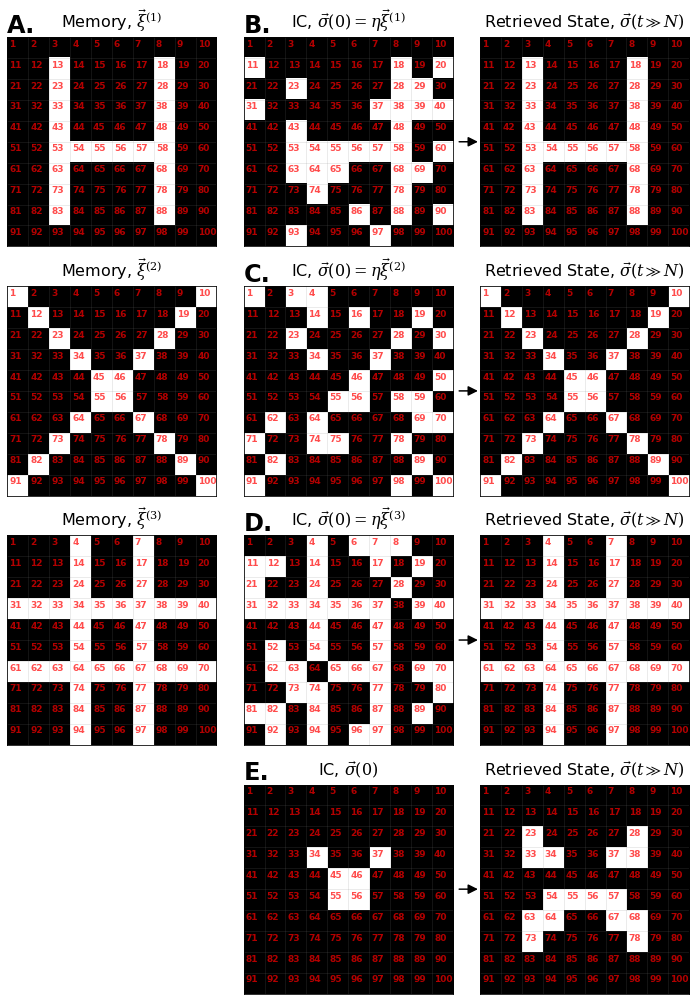

In [ ]:
xi_lst  = copy.deepcopy(xi_lst_all)
s_init  = copy.deepcopy(s_init_all)
s_final = copy.deepcopy(s_final_all)

xi_lst.append( xi_lst_all[0])
s_init.append( s_init_hall3 )
s_final.append(s_final_hall3)


fig, axes = plt.subplots(len(xi_lst), 3, figsize=(10, 2+3 * len(xi_lst)), facecolor='w')
axes[3,0].set_visible(False)


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu,:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                N = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(N), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-0.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[2,1].text(-0.5,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[3,1].text(-0.5,-0.5,'E.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[3,1].set_title(r'IC, $\vec{\sigma}(0)$', fontsize=16, pad=10)

fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,1], axesB=axes[0,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[1,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[2,1], axesB=axes[2,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[3,1], axesB=axes[3,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

fig.savefig('figures/hopfield_3mem_detail.png',dpi=300,bbox_inches='tight')

plt.show()

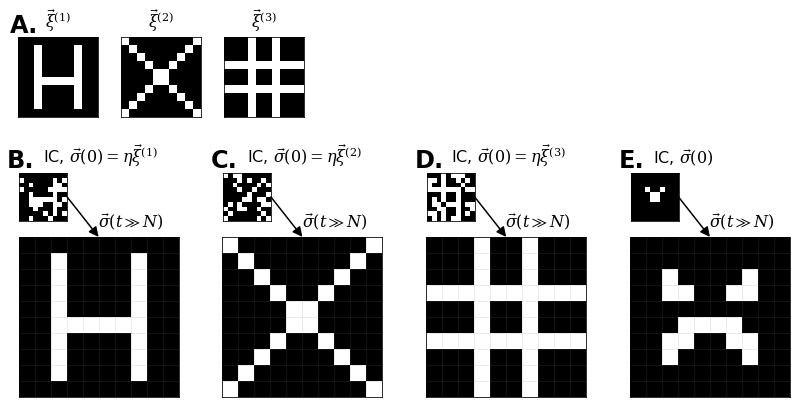

In [47]:
xi_lst  = copy.deepcopy(xi_lst_all)
s_init  = copy.deepcopy(s_init_all)
s_final = copy.deepcopy(s_final_all)

xi_lst.append( xi_lst_all[0])
s_init.append( s_init_hall3 )
s_final.append(s_final_hall3)


fig, axes = plt.subplots(3, len(xi_lst), figsize=(2+3 * len(xi_lst),10), facecolor='w')
axes[0,3].set_visible(False)


cmap = 'binary_r'

titles = [r'$\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'$\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[:,mu]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-1.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,0].text(-3.0,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-3.0,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,2].text(-3.0,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,3].text(-3.0,-0.5,'E.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,3].set_title(r'IC, $\vec{\sigma}(0)$', fontsize=16, pad=10)


pltt.enlarge_axis(axes[0,0],0.5,dx=-0.04)
pltt.enlarge_axis(axes[0,1],0.5,dx=-0.14)
pltt.enlarge_axis(axes[0,2],0.5,dx=-0.24)
pltt.enlarge_axis(axes[1,:],0.3,dx=-0.055, dy=0.1)
pltt.unset_minor_grid(axes[0:2,:])
pltt.shift_axes_title(axes[1,:3],dx=1.2,dy=-1)
pltt.shift_axes_title(axes[1,3] ,dx=0.6,dy=-1)
pltt.enlarge_axis(axes[2,:],1,dx=0, dy=0.2)
pltt.shift_axes_title(axes[2,:],dx=0.2,dy=-1)

#fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,0], axesB=axes[2,0], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[2,1], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,2], axesB=axes[2,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,3], axesB=axes[2,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

fig.savefig('figures/hopfield_3mem.png',dpi=300,bbox_inches='tight')

plt.show()

# energy plot

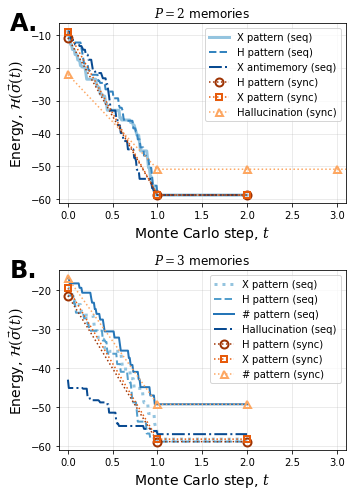

In [48]:
def _t(E,scale=1.0):
    return scale*np.arange(E.size)

# Plotting the trace
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig,ax = plt.subplots(2,1,figsize=(5,7))


colors_seq  = plt.get_cmap('Blues')(  np.linspace(0.4,0.9,10))
colors_sync = plt.get_cmap('Oranges')(np.linspace(0.4,0.9,10))


ax[0].plot(_t(E_lst_seq_HX[1] ,(1/N)),E_lst_seq_HX[1] , '-' , color=colors_seq[0] , linewidth=3  , label='X pattern (seq)'   )                                                          #'#D46600'#'#50ad9f'
ax[0].plot(_t(E_lst_seq_HX[0] ,(1/N)),E_lst_seq_HX[0] , '--', color=colors_seq[5] , linewidth=2  , label='H pattern (seq)'   )                                                          #'#1984c5'#'#0000a2'
ax[0].plot(_t(E_seq_anti      ,(1/N)),E_seq_anti      , '-.', color=colors_seq[9] , linewidth=2  , label='X antimemory (seq)')                                                          #'#D46600'#'#50ad9f'
ax[0].plot(_t(E_lst_sync_HX[0],     ),E_lst_sync_HX[0], 'o:', color=colors_sync[9], linewidth=1.5, label='H pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=8)#'#4daf4a'#'#bc272d'
ax[0].plot(_t(E_lst_sync_HX[1],     ),E_lst_sync_HX[1], 's:', color=colors_sync[5], linewidth=1.5, label='X pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=6)#'#e0169c'#'#e9c716'
ax[0].plot(_t(E_sync_hall     ,     ),E_sync_hall     , '^:', color=colors_sync[0], linewidth=1.5, label='Hallucination (sync)', markerfacecolor='none', markeredgewidth=2, markersize=7)#'#e0169c'#'#e9c716'
ax[0].set_title("$P=2$ memories")
ax[0].set_xlabel("Monte Carlo step, $t$",fontsize=14)
ax[0].set_ylabel(r"Energy, $\mathcal{H}(\vec{\sigma}(t))$",fontsize=14)
ax[0].set_xlim((-0.1,3.1))
ax[0].grid(alpha=0.3)
ax[0].legend(fontsize=10)


ax[1].plot(_t(E_lst_seq_all[1] ,(1/N)),E_lst_seq_all[1] , ':' , color=colors_seq[0], linewidth=3  , label='X pattern (seq)'    )                                                          #'#D46600'#'#50ad9f'
ax[1].plot(_t(E_lst_seq_all[0] ,(1/N)),E_lst_seq_all[0] , '--', color=colors_seq[3], linewidth=2  , label='H pattern (seq)'    )                                                          #'#1984c5'#'#0000a2'
ax[1].plot(_t(E_lst_seq_all[2] ,(1/N)),E_lst_seq_all[2] , '-' , color=colors_seq[6], linewidth=2  , label='# pattern (seq)'    )                                                          #'#1984c5'#'#0000a2'
ax[1].plot(_t(E_seq_hall3      ,(1/N)),E_seq_hall3      , '-.', color=colors_seq[9], linewidth=2  , label='Hallucination (seq)')                                                          #'#D46600'#'#50ad9f'
ax[1].plot(_t(E_lst_sync_all[0],     ),E_lst_sync_all[0], 'o:', color=colors_sync[9], linewidth=1.5, label='H pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=8)#'#4daf4a'#'#bc272d'
ax[1].plot(_t(E_lst_sync_all[1],     ),E_lst_sync_all[1], 's:', color=colors_sync[5], linewidth=1.5, label='X pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=6)#'#e0169c'#'#e9c716'
ax[1].plot(_t(E_lst_sync_all[2],     ),E_lst_sync_all[2], '^:', color=colors_sync[0], linewidth=1.5, label='# pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=7)#'#e0169c'#'#e9c716'
ax[1].set_title("$P=3$ memories")
ax[1].set_xlabel("Monte Carlo step, $t$",fontsize=14)
ax[1].set_ylabel(r"Energy, $\mathcal{H}(\vec{\sigma}(t))$",fontsize=14)
ax[1].set_xlim((-0.1,3.1))
ax[1].grid(alpha=0.3)
ax[1].legend(fontsize=10)#, loc='upper right', bbox_to_anchor=(1.02,1.08))

#pltt.shift_axes_title(ax,dx=-0.33)

ax[0].text(-0.65,-10,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
ax[1].text(-0.65,-18,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

fig.tight_layout()

fig.savefig('figures/hopfield_energy.png',dpi=300,bbox_inches='tight',facecolor='w')


plt.show()

# Overlap plot

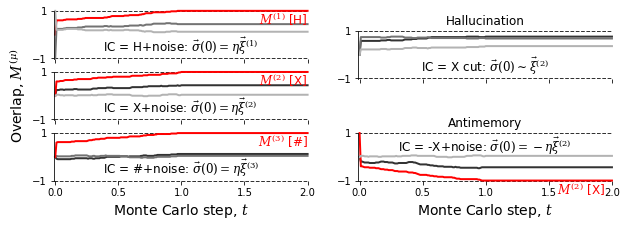

In [3]:

colors_gray  = plt.get_cmap('gray')(np.linspace(0.2,0.7,3))
colors1      = colors_gray.copy()
colors1[0,:] = np.array((1,0,0,1),dtype=float)
colors2      = colors_gray.copy()
colors2[1,:] = np.array((1,0,0,1),dtype=float)
colors3      = colors_gray.copy()
colors3[2,:] = np.array((1,0,0,1),dtype=float)


labels_all = np.array(['$M^{(1)}$ [H]','$M^{(2)}$ [X]','$M^{(3)}$ [#]'])
labels1    = labels_all.copy()
labels2    = labels_all.copy()
labels3    = labels_all.copy()
labels1[[1,2]]=''
labels2[[0,2]]=''
labels3[[0,1]]=''

m_seq_anti_plot = np.vstack((m_seq_anti,m_lst_seq_all[1][2,:]))

fig, ax = plt.subplots(nrows=3,ncols=2,sharex=True,figsize=(10, 6), facecolor='w')
pltt.plot_overlap_evolution(ax[0,0], m_lst_seq_all[0], t_scale=1/N,
                        labels=labels1,
                        label_args=dict(fontsize=12),
                        line_args=dict(linewidth=2),
                        colors=colors1)
pltt.plot_overlap_evolution(ax[1,0], m_lst_seq_all[1], t_scale=1/N,
                        labels=labels2,
                        label_args=dict(fontsize=12),
                        line_args=dict(linewidth=2),
                        colors=colors2)
pltt.plot_overlap_evolution(ax[2,0], m_lst_seq_all[2], t_scale=1/N,
                        labels=labels3,
                        label_args=dict(fontsize=12),
                        line_args=dict(linewidth=2),
                        colors=colors3)
pltt.plot_overlap_evolution(ax[1,1], m_seq_hall_3, t_scale=1/N,
                        labels=None,
                        t_label=[199,160,199],
                        label_args=dict(fontsize=12),
                        line_args=dict(linewidth=2),
                        colors=colors_gray)
pltt.plot_overlap_evolution(ax[2,1], m_seq_anti_plot, t_scale=1/N,
                        labels=labels2,
                        t_label=[200,195],
                        label_args=dict(fontsize=12),
                        line_args=dict(linewidth=2),
                        colors=colors2)
ax[0,0].text(0.5, 0.05,r"IC = H+noise: $\vec{\sigma}(0)=\eta\vec{\xi}^{(1)}$"  , fontsize=12, transform=ax[0,0].transAxes, ha='center', va='bottom')
ax[1,0].text(0.5, 0.05,r"IC = X+noise: $\vec{\sigma}(0)=\eta\vec{\xi}^{(2)}$"  , fontsize=12, transform=ax[1,0].transAxes, ha='center', va='bottom')
ax[2,0].text(0.5, 0.05,r"IC = #+noise: $\vec{\sigma}(0)=\eta\vec{\xi}^{(3)}$"  , fontsize=12, transform=ax[2,0].transAxes, ha='center', va='bottom')
ax[1,1].text(0.5, 0.05,r"IC = X cut: $\vec{\sigma}(0)\sim\vec{\xi}^{(2)}$"     , fontsize=12, transform=ax[1,1].transAxes, ha='center', va='bottom')
ax[2,1].text(0.5, 0.95,r"IC = -X+noise: $\vec{\sigma}(0)=-\eta\vec{\xi}^{(2)}$", fontsize=12, transform=ax[2,1].transAxes, ha='center', va='top')
ax[0,0].set_xlim(left=-0.01)
ax[2,0].set_xlabel("Monte Carlo step, $t$", fontsize=14)
ax[2,1].set_xlabel("Monte Carlo step, $t$", fontsize=14)
ax[1,0].set_ylabel("Overlap, $M^{(\\mu)}$", fontsize=14)

ax[1,1].set_title('Hallucination')
ax[2,1].set_title('Antimemory')

pltt.enlarge_axis(ax,my=0.5)
pltt.enlarge_axis(ax[1,0],dy=0.125)
pltt.enlarge_axis(ax[2,0],dy=0.25)
pltt.enlarge_axis(ax[1,1],dy=0.22)
pltt.enlarge_axis(ax[2,1],dy=0.25)

#ax[2,1].set_visible(False)
#ax[2,1].set_subplotspec(None)
ax[0,1].axis('off')

fig.savefig('figures/hopfield_overlap.png',dpi=300,bbox_inches='tight')

plt.show()

# lattice representation of network state

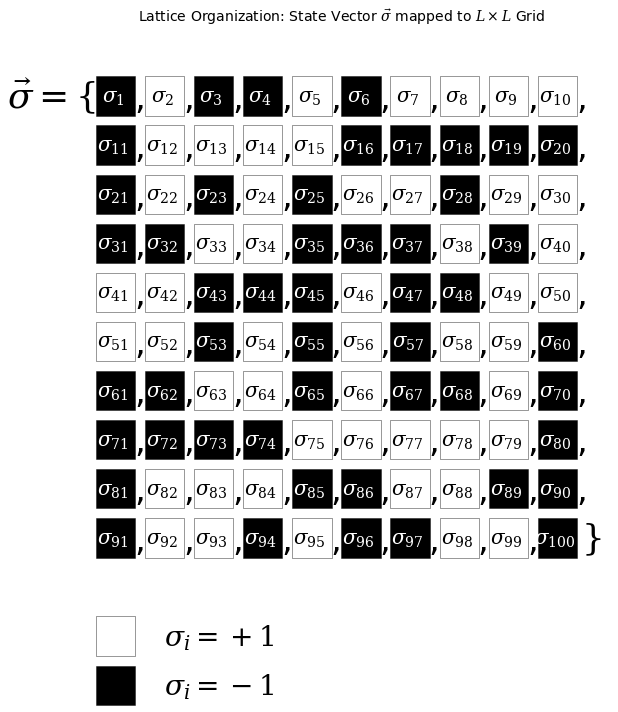

In [ ]:

    
# Example usage:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
pltt.plot_vector_lattice_schematic(ax,hopfield.add_noise(pattern_H,0.5).reshape(10, 10), L=10)
plt.title(r"Lattice Organization: State Vector $\vec{\sigma}$ mapped to $L \times L$ Grid", 
            fontsize=14, pad=20)
    
plt.tight_layout()
plt.show()


# Spin glass - Energy of random interactions

<ipython-input-1-7b542cc2f201>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


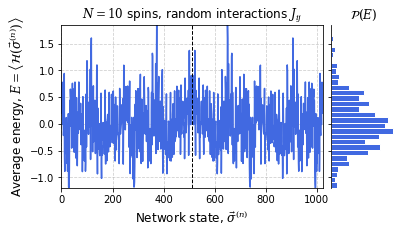

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import modules.hopfield as hopfield


plt.rcParams["mathtext.fontset"] = "dejavuserif"


# 1. Generate the states (using the efficient bit-shift method)
np.random.seed(42)
n_samples   = 100
dist_type   = hopfield.DistributionType.Normal
N           = 10
half_states = hopfield.generate_ising_states(N)

# 2. Define a random symmetric coupling matrix J (N x N)

# 3. Vectorized Energy Calculation (Fastest method)
# np.einsum performs the sum over spins for all configurations simultaneously
avg_energies = np.mean([-0.5 * np.einsum('ki,ij,kj->k', half_states, hopfield.generate_random_interaction_matrix(N, dist_type=dist_type), half_states) for _ in range(n_samples)],axis=0)

# Create the figure with GridSpec (4:1 ratio)
fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.05)

# 1. Main Plot: Energy vs State Index
ax1 = fig.add_subplot(gs[0])
spin_state_index = np.arange(2*len(avg_energies))
ax1.plot(spin_state_index, np.hstack((avg_energies,avg_energies[::-1])), color='royalblue', alpha=1.0)
ax1.set_title(f"$N={N}$ spins, random interactions $J_{{ij}}$")
ax1.set_xlabel(r"Network state, $\vec{\sigma}^{(n)}$", fontsize=12)
ax1.set_ylabel(r"Average energy, $E=\left\langle\mathcal{H}\left(\vec{\sigma}^{(n)}\right)\right\rangle$", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.autoscale(tight=True)
ax1.axvline(512,ls='--', c='k', lw=1)

# 2. Side Plot: Vertical Histogram
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2.hist(np.hstack((avg_energies,avg_energies[::-1])), bins=30, orientation='horizontal', color='royalblue', alpha=1.0, edgecolor='white',density=True)
ax2.set_title(r'$\mathcal{P}(E)$')
#ax2.set_xlabel(r"$\mathcal{P}(E)$",fontsize=12)
ax2.tick_params(axis='y', labelleft=False) # Remove redundant labels
ax2.set_xticks([])
#ax2.grid(True, axis='x', linestyle='--', alpha=0.6)
# --- Styling to turn off spines ---
for spine in ['top', 'right', 'bottom']:
    ax2.spines[spine].set_visible(False)

plt.tight_layout()

fig.savefig('figures/ising_spin_glass_energy.png',dpi=300,bbox_inches='tight', facecolor='w')

plt.show()